In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

tables = {
    "OE_Activity": "../data/database_backups_csv/OE/OE_Activity.csv",
    "OE_Locations": "../data/database_backups_csv/OE/OE_Locations.csv",
    "OE_Products": "../data/database_backups_csv/OE/OE_Products.csv",
}

column_names = {
    "OE_Activity": ["ActivityCode","UserID","WorkCode","AssignmentID","ProductID","Quantity","Timestamp","LocationID"],
    "OE_Locations": ["LocationID","Aisle","Bay","Level","Slot"],
    "OE_Products": ["ProductID","ProductCode","UnitOfMeasure","Weight","Cube","Length","Width","Height"],
}

dfs = {}
for name, fp in tables.items():
    dfs[name] = pd.read_csv(fp)
    dfs[name].columns = column_names[name]

In [6]:
for t in ["OE_Activity", "OE_Locations", "OE_Products"]:
    print("=" * 80)
    print(f"Table: {t}")

    df = dfs[t]
    print(f"Dimensions: ({df.shape[0]} rows, {df.shape[1]} columns)\n")

    display(df.head(3))

    # Columns and data types + quick summary stats
    schema_df = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "n_missing": df.isna().sum(),
        "n_unique": df.nunique(dropna=True),
    })

    # Numeric summaries
    num_df = df.select_dtypes(include="number")
    schema_df["min"] = num_df.min()
    schema_df["max"] = num_df.max()
    schema_df["mean"] = num_df.mean()

    display(schema_df)
    print("\n")

Table: OE_Activity
Dimensions: (96131 rows, 8 columns)



,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID
0,AssignmentOpen,64,10,7954429,NaN,NaN,2025-11-10 11:38:34.043,NaN
1,PickPut,419,20,7954541,6592.0,1.0,2025-11-10 11:39:42.330,14524.0
2,PickPut,419,20,7954542,6592.0,1.0,2025-11-10 11:39:42.883,14524.0


,dtype,n_missing,n_unique,min,max,mean
ActivityCode,object,0,2,NaN,NaN,NaN
UserID,int64,0,40,64.0,504.0,4.050260e+02
WorkCode,int64,0,3,10.0,30.0,2.642041e+01
AssignmentID,int64,0,42240,7717782.0,8042473.0,7.924902e+06
ProductID,float64,894,7691,1.0,57791.0,2.477799e+04
Quantity,float64,894,144,1.0,1143.0,8.453553e+00
Timestamp,object,0,95803,NaN,NaN,NaN
LocationID,float64,894,7669,1.0,8104198.0,8.932254e+05




Table: OE_Locations
Dimensions: (33518 rows, 5 columns)



,LocationID,Aisle,Bay,Level,Slot
0,2,40,5.0,4.0,4.0
1,3,40,9.0,1.0,2.0
2,4,42,21.0,6.0,3.0


,dtype,n_missing,n_unique,min,max,mean
LocationID,int64,0,33518,2.0,8034868.0,795298.495167
Aisle,object,0,52,NaN,NaN,NaN
Bay,float64,1,86,1.0,99.0,23.107080
Level,float64,1,12,1.0,50.0,3.687233
Slot,float64,1,35,1.0,35.0,3.019304




Table: OE_Products
Dimensions: (57670 rows, 8 columns)



,ProductID,ProductCode,UnitOfMeasure,Weight,Cube,Length,Width,Height
0,2,0204800418,BX,2.7338,0.263,NaN,NaN,NaN
1,3,07062B1322Q,EA,0.6500,0.027,NaN,NaN,NaN
2,4,07062B1324X,EA,2.4500,0.052,NaN,NaN,NaN


,dtype,n_missing,n_unique,min,max,mean
ProductID,int64,0,57670,2.0,57671.000,28836.500000
ProductCode,object,0,41981,NaN,NaN,NaN
UnitOfMeasure,object,0,55,NaN,NaN,NaN
Weight,float64,0,5572,0.0,7584.000,4.834325
Cube,float64,0,4009,0.0,421.296,0.623217
Length,float64,57670,0,NaN,NaN,NaN
Width,float64,57670,0,NaN,NaN,NaN
Height,float64,57670,0,NaN,NaN,NaN


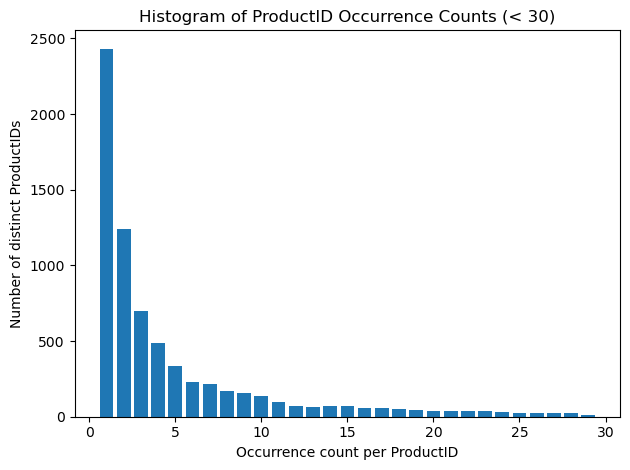

In [7]:
activity = dfs["OE_Activity"]

product_counts = (
    activity.groupby("ProductID", dropna=False)
    .size()
    .reset_index(name="occ_cnt")
)

# Count-of-counts for occ_cnt < 30
count_of_counts = (
    product_counts.loc[product_counts["occ_cnt"] < 30, "occ_cnt"]
    .value_counts()
    .sort_index()
)

plt.figure()
plt.bar(count_of_counts.index, count_of_counts.values)
plt.xlabel("Occurrence count per ProductID")
plt.ylabel("Number of distinct ProductIDs")
plt.title("Histogram of ProductID Occurrence Counts (< 30)")
plt.tight_layout()
plt.show()


In [8]:
total_products = product_counts.shape[0]

pct_occ_1 = ((product_counts["occ_cnt"] == 1).sum() / total_products * 100)
pct_occ_gt_10 = ((product_counts["occ_cnt"] > 10).sum() / total_products * 100)
pct_occ_gt_50 = ((product_counts["occ_cnt"] > 50).sum() / total_products * 100)

print(f"Percentage of ProductIDs with occurrence = 1: {pct_occ_1:.2f}%")
print(f"Percentage of ProductIDs with occurrence > 10: {pct_occ_gt_10:.2f}%")
print(f"Percentage of ProductIDs with occurrence > 50: {pct_occ_gt_50:.2f}%")

Percentage of ProductIDs with occurrence = 1: 31.62%
Percentage of ProductIDs with occurrence > 10: 20.63%
Percentage of ProductIDs with occurrence > 50: 5.25%


In [ ]:
qty_df = dfs["OE_Activity"][["Quantity"]].dropna()

qty_df["Quantity"] = pd.to_numeric(qty_df["Quantity"], errors="coerce")
qty_df = qty_df.dropna()

pct_qty_1 = (qty_df["Quantity"] == 1).mean() * 100
print(f"Percentage of rows with Quantity = 1: {pct_qty_1:.2f}%")

Percentage of rows with Quantity = 1: 38.22%


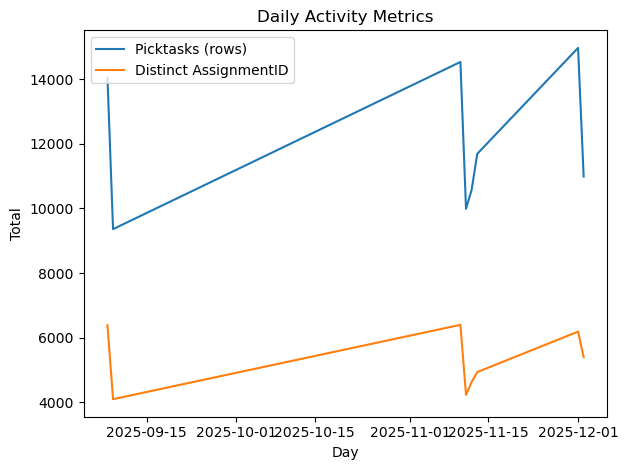

,day,picktasks,distinct_assignments,total_quantity,distinct_workers
0,2025-09-08,14043,6385,116746,29
1,2025-09-09,9358,4096,75060,33
2,2025-11-10,14532,6396,126409,31
3,2025-11-11,9988,4228,78577,32
4,2025-11-12,10569,4627,89059,30


In [ ]:
activity = dfs["OE_Activity"].copy()

# Parse Timestamp to datetime
activity["Timestamp"] = pd.to_datetime(activity["Timestamp"], errors="coerce")

daily = (
    activity.dropna(subset=["Timestamp"])
    .assign(day=lambda d: d["Timestamp"].dt.date)
    .groupby("day")
    .agg(
        picktasks=("Timestamp", "size"),
        distinct_assignments=("AssignmentID", pd.Series.nunique),
        total_quantity=("Quantity", lambda s: pd.to_numeric(s, errors="coerce").fillna(0).astype("int64").sum()),
        distinct_workers=("UserID", pd.Series.nunique),
    )
    .reset_index()
    .sort_values("day")
)

daily["day"] = pd.to_datetime(daily["day"])

plt.figure()
plt.plot(daily["day"], daily["picktasks"], label="Picktasks (rows)")
plt.plot(daily["day"], daily["distinct_assignments"], label="Distinct AssignmentID")

plt.xlabel("Day")
plt.ylabel("Total")
plt.title("Daily Activity Metrics")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

daily.head()
